## Preliminaries

In [5]:
import numpy as np
import scipy as sp
import scipy.ndimage
import deeppy as dp
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def plot_img(img, title=''):
    plt.figure(figsize=(8,12))
    if img.ndim == 3:
        cmap = None
    else:
        cmap = 'gray'
    plt.imshow(img, cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

## ZCA/LCN implementation

In [6]:
class ZCA():
    def __init__(self, bias=0.1):
        self.bias = bias

    def _flat(self, x):
        return np.reshape(x, (x.shape[0], -1))
    
    def _normalize(self, x):
        return (x.astype(np.float_) - self._mean) / self._std
    
    def fit(self, x):
        x = self._flat(x)
        self._mean = np.mean(x, axis=0, dtype=np.float64).astype(x.dtype)
        self._std = np.std(x, axis=0, dtype=np.float64).astype(x.dtype)
        x = self._normalize(x)
        try:
            # Perform dot product on GPU
            import cudarray as ca
            x_ca = ca.array(x)
            cov = np.array(ca.dot(x_ca.T, x_ca)).astype(np.float_)
        except:
            cov = np.dot(x.T, x)
        cov = cov / x.shape[0] + self.bias * np.identity(x.shape[1])
        s, v = np.linalg.eigh(cov)
        s = np.diag(1.0 / np.sqrt(s))
        self.whitener = np.dot(np.dot(v, s), v.T)
        return self

    def transform(self, x):
        shape = x.shape
        x = self._flat(x)
        x = self._normalize(x)
        x_white = np.dot(x, self.whitener.T)
        return np.reshape(x_white, shape)
        

class LCN():
    @staticmethod
    def gaussian_kernel(sigma, size=None):
        if size is None:
            size = int(np.ceil(sigma*2.))
            if size % 2 == 0:
                size += 1
        xs = np.linspace(-size/2., size/2., size)
        kernel = 1/(np.sqrt(2*np.pi))*np.exp(-xs**2/(2*sigma**2))/sigma
        return kernel/np.sum(kernel)

    def __init__(self, sigma, eps=1e-1, subtractive=False):
        self.sigma = sigma
        self.eps = eps
        self.subtractive = subtractive
        self.kernel = LCN.gaussian_kernel(sigma, size=int(sigma*3))
        self.kernel = np.outer(self.kernel, self.kernel)
    
    def _normalize(self, x):
        return (x.astype(np.float_) - self._mean) / self._std

    def fit(self, x):
        self._mean = np.mean(x, dtype=np.float64).astype(x.dtype)
        self._std = np.std(x, dtype=np.float64).astype(x.dtype)
        return self

    def _transform_img(self, img):
        if img.ndim == 2:
            img = img[np.newaxis, :, :]
        n_channels = img.shape[0]

        # Calculate local mean
        mean = np.zeros((1,) + img.shape[1:])
        for i in range(n_channels):
            mean += sp.ndimage.filters.convolve(img[i], self.kernel, mode='nearest')
        mean /= n_channels

        # Center input with local mean
        centered = img - mean
        if self.subtractive:
            return centered

        # Calculate local standard deviation
        centered_sqr = centered**2
        std = np.zeros((1,) + img.shape[1:])
        for i in range(n_channels):
            std += sp.ndimage.filters.convolve(centered_sqr[i], self.kernel, mode='nearest')
        std /= n_channels
        std = np.sqrt(std)

        # Scale centered input with standard deviation
        return centered / (std + self.eps) 

    def transform(self, x):
        x = self._normalize(x)
        return np.array([self._transform_img(img) for img in x])

## Load dataset

In [7]:
dataset = dp.dataset.CIFAR10()
x_train, y_train, x_test, y_test = dataset.data()

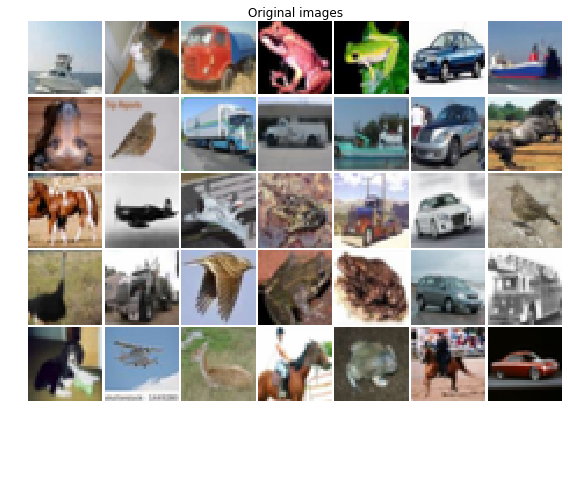

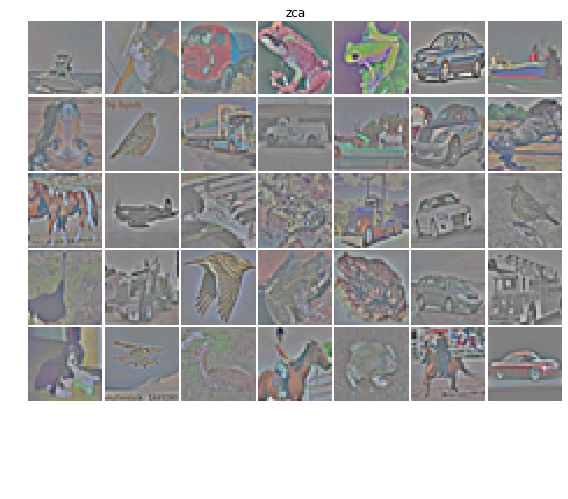

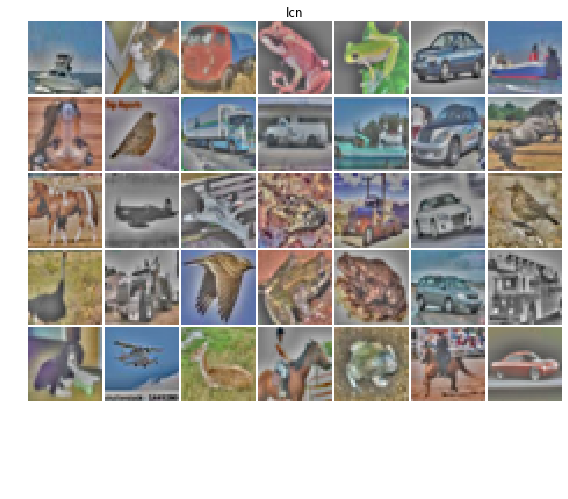

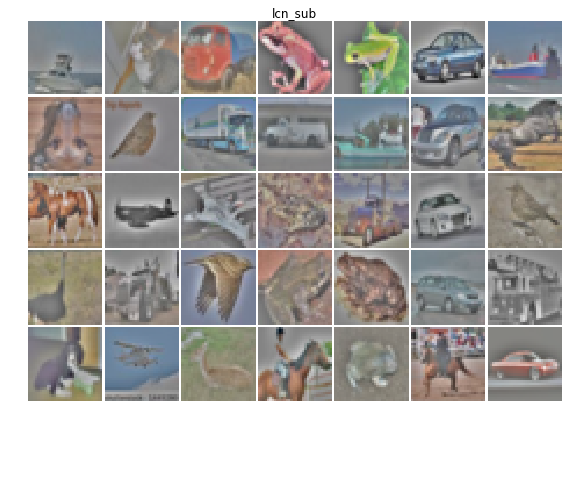

In [8]:
methods = [
   ('zca', ZCA(bias=0.5)),
   ('lcn', LCN(sigma=4, eps=0.05, subtractive=False)),
   ('lcn_sub', LCN(sigma=4, subtractive=True))
]

x_white = x_train[100:135]
x_white = np.transpose(x_white, (0, 2, 3, 1))
plot_img(dp.misc.img_tile(dp.misc.img_stretch(x_white), aspect_ratio=0.75, border_color=1.0), 'Original images')
plt.savefig('whitening_imgs.png')

for name, method in methods:
    method.fit(x_train)
    x_white = x_train[100:135]
    x_white = method.transform(x_white)
    if x_white.ndim == 4:
        x_white = np.transpose(x_white, (0, 2, 3, 1))
    plot_img(dp.misc.img_tile(dp.misc.img_stretch(x_white), aspect_ratio=0.75, border_color=1.0), name)